# Chapter 8 - Scaling Up GNNs with GraphSAGE

GraphSAGE (Graph Sample and Aggregation) is a framework for inductive representation learning on large graphs
>The key technical decisions behind GraphSAGE include:
    >>Inductive Learning: Unlike transductive methods, GraphSAGE can generate embeddings for previously unseen nodes, making it scalable and adaptable
    >>Neighbor Sampling: It uses neighbor sampling to efficiently generate embeddings by sampling and aggregating features from a node's local neighborhood
    >>Aggregation Functions: GraphSAGE employs various aggregation functions (mean, LSTM, pooling) to combine features from neighbors, allowing flexibility in capturing different types of information
    >>Layer-wise Training: The model is trained layer-by-layer, which helps in learning hierarchical representations of nodes

PinSage (Pinterest SAGE) is a Graph Convolutional Network (GCN) designed for web-scale recommender systems
>The key technical decisions behind PinSage include:
    >>Random Walks: PinSage uses random walks to sample relevant subgraphs, which helps in capturing the local structure of the graph
    >>Graph Convolution: It combines efficient random walks with graph convolutions to generate embeddings that incorporate both graph structure and node features
    >>Dynamic Graph Construction: PinSage dynamically constructs graphs based on user interactions, ensuring that the embeddings are up-to-date and relevant
    >>Distributed Computing: To handle web-scale data, PinSage employs distributed computing techniques to scale efficiently and handle billions of items and users

Classifying nodes on PubMed

In [1]:
import torch
torch.manual_seed(-1)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
#Downloading the dataset and exploring it
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Done!


In [3]:
#Using the NeigborLoader to create neighbor samplings from the dataset with 5 neighbors for the 1-hop and 10 neighbors for the 2-hop along with batch size of 16
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],
    batch_size=10,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[357, 500], edge_index=[2, 428], y=[357], train_mask=[357], val_mask=[357], test_mask=[357], n_id=[357], e_id=[428], input_id=[10], batch_size=10)
Subgraph 1: Data(x=[264, 500], edge_index=[2, 359], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], n_id=[264], e_id=[359], input_id=[10], batch_size=10)
Subgraph 2: Data(x=[169, 500], edge_index=[2, 181], y=[169], train_mask=[169], val_mask=[169], test_mask=[169], n_id=[169], e_id=[181], input_id=[10], batch_size=10)
Subgraph 3: Data(x=[147, 500], edge_index=[2, 170], y=[147], train_mask=[147], val_mask=[147], test_mask=[147], n_id=[147], e_id=[170], input_id=[10], batch_size=10)
Subgraph 4: Data(x=[329, 500], edge_index=[2, 404], y=[329], train_mask=[329], val_mask=[329], test_mask=[329], n_id=[329], e_id=[404], input_id=[10], batch_size=10)
Subgraph 5: Data(x=[138, 500], edge_index=[2, 168], y=[138], train_mask=[138], val_mask=[138], test_mask=[138], n_id=[138], e_id=[168], input_id=[10], batch_size=10)


In [4]:
x = zip(train_loader, [221, 222, 223, 224])
print(tuple(x))

((Data(x=[356, 500], edge_index=[2, 431], y=[356], train_mask=[356], val_mask=[356], test_mask=[356], n_id=[356], e_id=[431], input_id=[10], batch_size=10), 221), (Data(x=[266, 500], edge_index=[2, 366], y=[266], train_mask=[266], val_mask=[266], test_mask=[266], n_id=[266], e_id=[366], input_id=[10], batch_size=10), 222), (Data(x=[162, 500], edge_index=[2, 181], y=[162], train_mask=[162], val_mask=[162], test_mask=[162], n_id=[162], e_id=[181], input_id=[10], batch_size=10), 223), (Data(x=[158, 500], edge_index=[2, 176], y=[158], train_mask=[158], val_mask=[158], test_mask=[158], n_id=[158], e_id=[176], input_id=[10], batch_size=10), 224))


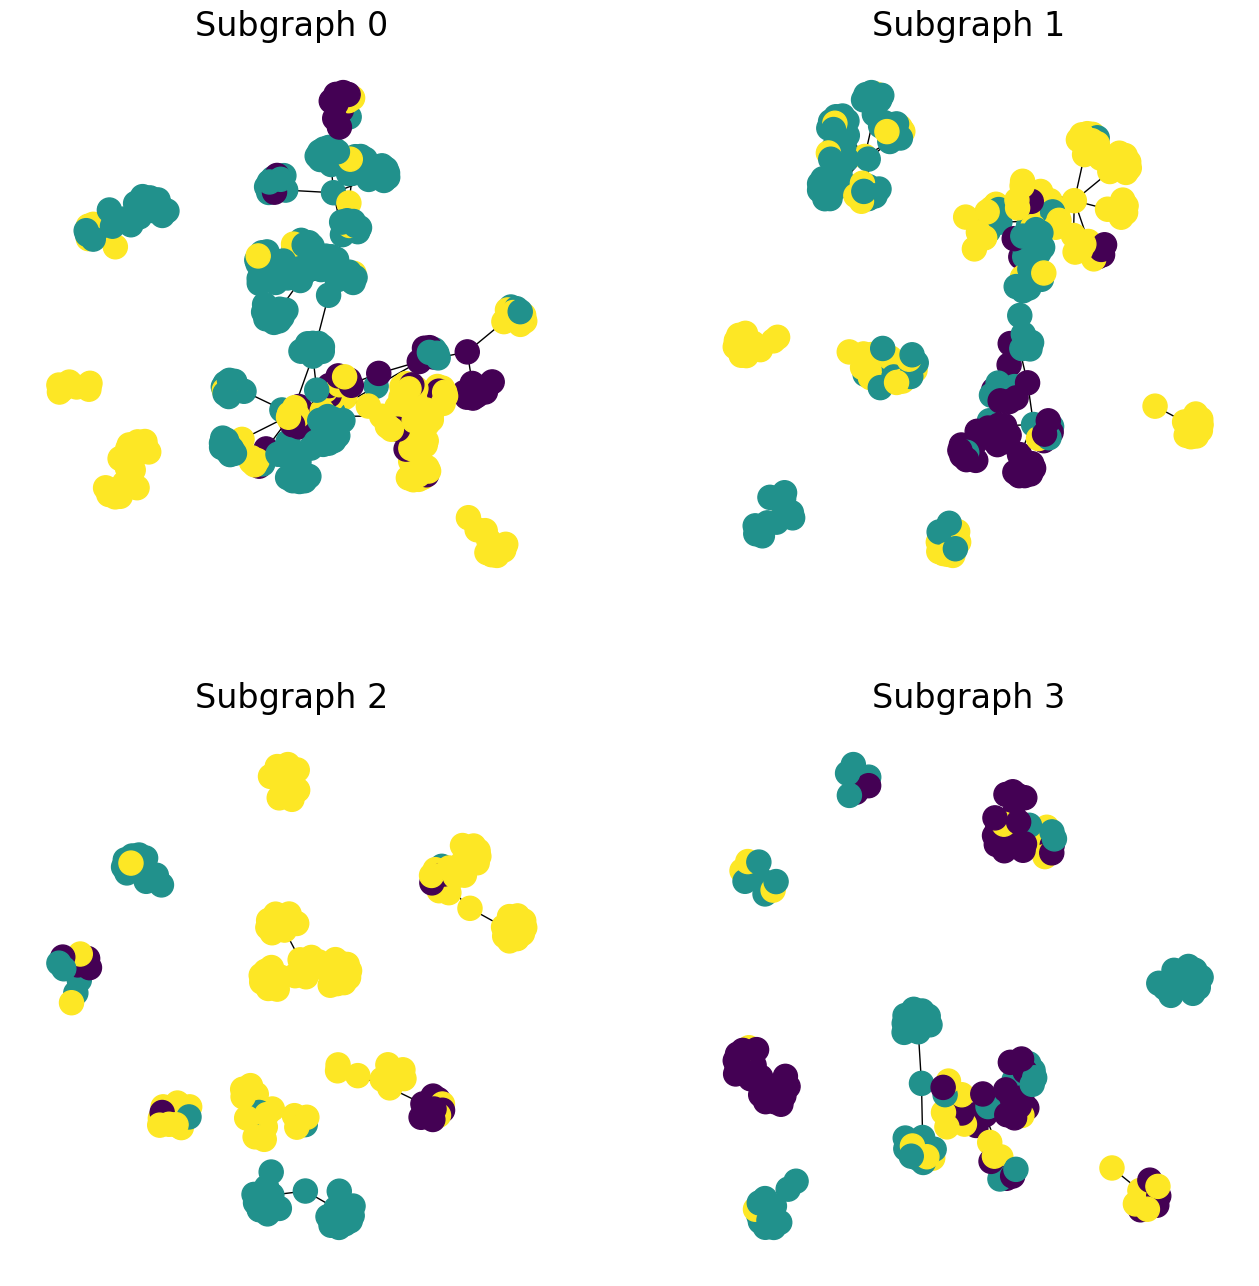

In [5]:
#Plotting the subgraphs
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [6]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [7]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(train_loader, 200)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.221 | Train Acc:  31.97% | Val Loss: 1.12 | Val Acc: 29.86%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 69.07%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 78.15%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.40 | Val Acc: 83.98%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.82 | Val Acc: 66.75%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 72.22%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 74.52%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 73.56%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.87 | Val Acc: 69.86%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.89 | Val Acc: 76.39%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00

The example above is transducive learning because we mask the test dataset during training

Inductive learning on protein-protein interactions

In [8]:
import torch
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training, evaluation, and test sets
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# Unify the training graphs and apply neighbor sampling
train_data = Batch.from_data_list(train_dataset)
train_loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Evaluation loaders (one datapoint corresponds to a graph)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

Extracting ./ppi.zip
Processing...
Done!


In [9]:
#Creating the GraphSAGE model
model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit(loader):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.data)

@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

for epoch in range(301):
    loss = fit(train_loader)
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

print(f'Test F1-score: {test(test_loader):.4f}')

Epoch   0 | Train Loss: 12.697 | Val F1-score: 0.4846
Epoch  50 | Train Loss: 8.743 | Val F1-score: 0.7953
Epoch 100 | Train Loss: 8.602 | Val F1-score: 0.8123
Epoch 150 | Train Loss: 8.560 | Val F1-score: 0.8192
Epoch 200 | Train Loss: 8.501 | Val F1-score: 0.8228
Epoch 250 | Train Loss: 8.465 | Val F1-score: 0.8252
Epoch 300 | Train Loss: 8.458 | Val F1-score: 0.8274
Test F1-score: 0.8518
